In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel,BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from gensim.models import Word2Vec

%pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
training_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv', sep=',').dropna()
testing_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv', sep=',').dropna()
validation_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv').dropna()

# combined_data = combined_data.sample(frac = 1)
training_data.head()
print(training_data.info(), end="\n=====================================\n")
print(testing_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2736 non-null   object
 1   label   2736 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    342 non-null    object
 1   label   342 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ KB
None


In [3]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_test = testing_data['label'].values.copy()
y_val = validation_data['label'].values.copy()

In [4]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', sep=',').dropna()
combined_data = combined_data.drop_duplicates().reset_index(drop=True)

In [5]:
texts = combined_data['text'].values
labels = combined_data['label'].values

In [6]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

# lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    sentences=[]
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]
        
        text = ' '.join(word_list)
        texts[index] = text
        sentences.append(word_list)
    return texts, sentences

In [7]:
texts_train,sentences = preprocess_text(texts_raw_train)
texts_val,_ = preprocess_text(texts_raw_val)
texts_test,_ = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

In [8]:
X_train = texts_train
X_test = texts_test
X_val = texts_val
y_train = training_data['label'].values
y_test = testing_data['label'].values
y_val = validation_data['label'].values

In [9]:
print(X_train)

['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .'
 'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru'
 'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+'
 ... 'Kerennn'
 'Saya merekomendasikan ρułau777 siapa mencari tempat terper

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer
# tokenized_texts = [text.split() for text in texts]
# word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# # Create feature vectors using Word2Vec
# def vectorize_texts(texts, model):
#     vectors = []
#     for text in texts:
#         tokens = text.split()
#         token_vectors = [model.wv[token] for token in tokens if token in model.wv]
#         if token_vectors:
#             text_vector = np.mean(token_vectors, axis=0)  # Average the token vectors
#         else:
#             text_vector = np.zeros(model.vector_size)  # Fallback for empty texts
#         vectors.append(text_vector)
#     return np.array(vectors)

# X = vectorize_texts(X_train, word2vec_model)
# y = np.array(y_train)

# # Now you can use X and y in your ML model
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# unique_labels, counts = np.unique(y_resampled, return_counts=True)
# for label, count in zip(unique_labels, counts):
#     print(f"Label {label}: {count}")

In [11]:
import numpy as np
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Tokenize & train Word2Vec dari seluruh data teks
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=4)

# 2. Fungsi vektorisasi menggunakan concatenation + padding
def sentence_vector_concat(sentence, model, max_len=50):
    words = sentence.split()
    vecs = []

    for word in words:
        if word in model.wv:
            vecs.append(model.wv[word])
        if len(vecs) == max_len:
            break

    while len(vecs) < max_len:
        vecs.append(np.zeros(model.vector_size))  # padding

    return np.concatenate(vecs)

# 3. Vektorisasi teks
X_train = np.array([sentence_vector_concat(text, word2vec_model, max_len=50) for text in texts_train])
X_test = np.array([sentence_vector_concat(text, word2vec_model, max_len=50) for text in texts_test])
X_val = np.array([sentence_vector_concat(text, word2vec_model, max_len=50) for text in texts_val])

# 4. Ambil label
y_train = training_data['label'].values
y_test = testing_data['label'].values
y_val = validation_data['label'].values

# 5. Oversampling pada data latih
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# 6. Cek distribusi label setelah oversampling
unique_labels, counts = np.unique(y_resampled, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 1997
Label 1: 1997


In [12]:
print(X_train)
print(X_train.shape)

[[-3.18988087e-03 -7.08792475e-04  1.49873574e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.01684839e-05 -1.44385104e-03  3.46298493e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.26924545e-03 -1.51223678e-03  2.27032253e-03 ... -1.20424235e-03
  -2.16109189e-03  1.67816703e-03]
 ...
 [ 3.62815859e-04  1.40554504e-04  3.24579724e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.70799985e-03  7.62257120e-03  6.11626543e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.14870027e-03  1.89766730e-03  7.49860192e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
(2736, 15000)


In [13]:
# 2. Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000,     # Banyak boosting rounds
    max_depth=20,          # Pohon lebih dalam
    use_label_encoder=False, 
    eval_metric='logloss', # Hindari warning
    verbosity=0
)
xgb_model.fit(X_resampled, y_resampled)

# 3. Evaluasi pada validation set
y_val_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='binary')  # ganti ke 'macro' jika multiclass
recall = recall_score(y_val, y_val_pred, average='binary')
f1 = f1_score(y_val, y_val_pred, average='binary')

print("Validation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation:
Accuracy: 0.9213
Precision: 0.9024
Recall: 0.7957
F1-score: 0.8457
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       250
           1       0.90      0.80      0.85        93

    accuracy                           0.92       343
   macro avg       0.91      0.88      0.90       343
weighted avg       0.92      0.92      0.92       343



In [14]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = xgb_model.predict(X_test)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(y_test, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")

Best Threshold: 1.0000
Best F1-Score: 0.8387
Average Precision (AP) Score: 0.7445


In [15]:
# Split data
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Train XGBoost model
# xgb_model = XGBClassifier(
#     n_estimators=1000,       # More boosting rounds
#     max_depth=20,            # Deeper trees
# )
# xgb_model.fit(X_resampled, y_resampled)

# X_val = vectorize_texts_flatten(X_val, word2vec_model)
# y_val = np.array(y_val)
# X_test = vectorize_texts_flatten(X_test, word2vec_model)
# y_test = np.array(y_test)
# # Predict and evaluate
# y_pred = xgb_model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)

# print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y_val, y_pred))

# precision = precision_score(y_val, y_pred)
# recall = recall_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")

In [24]:
# Evaluate model performance
pred = xgb_model.predict(X_test)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9123
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       250
           1       0.83      0.85      0.84        92

    accuracy                           0.91       342
   macro avg       0.89      0.89      0.89       342
weighted avg       0.91      0.91      0.91       342

Precision: 0.8298
Recall: 0.8478
F1-score: 0.8387


In [17]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, y_pred, average='binary', beta=0.5, pos_label=1)

0.8333333333333333

Confusion Matrix:



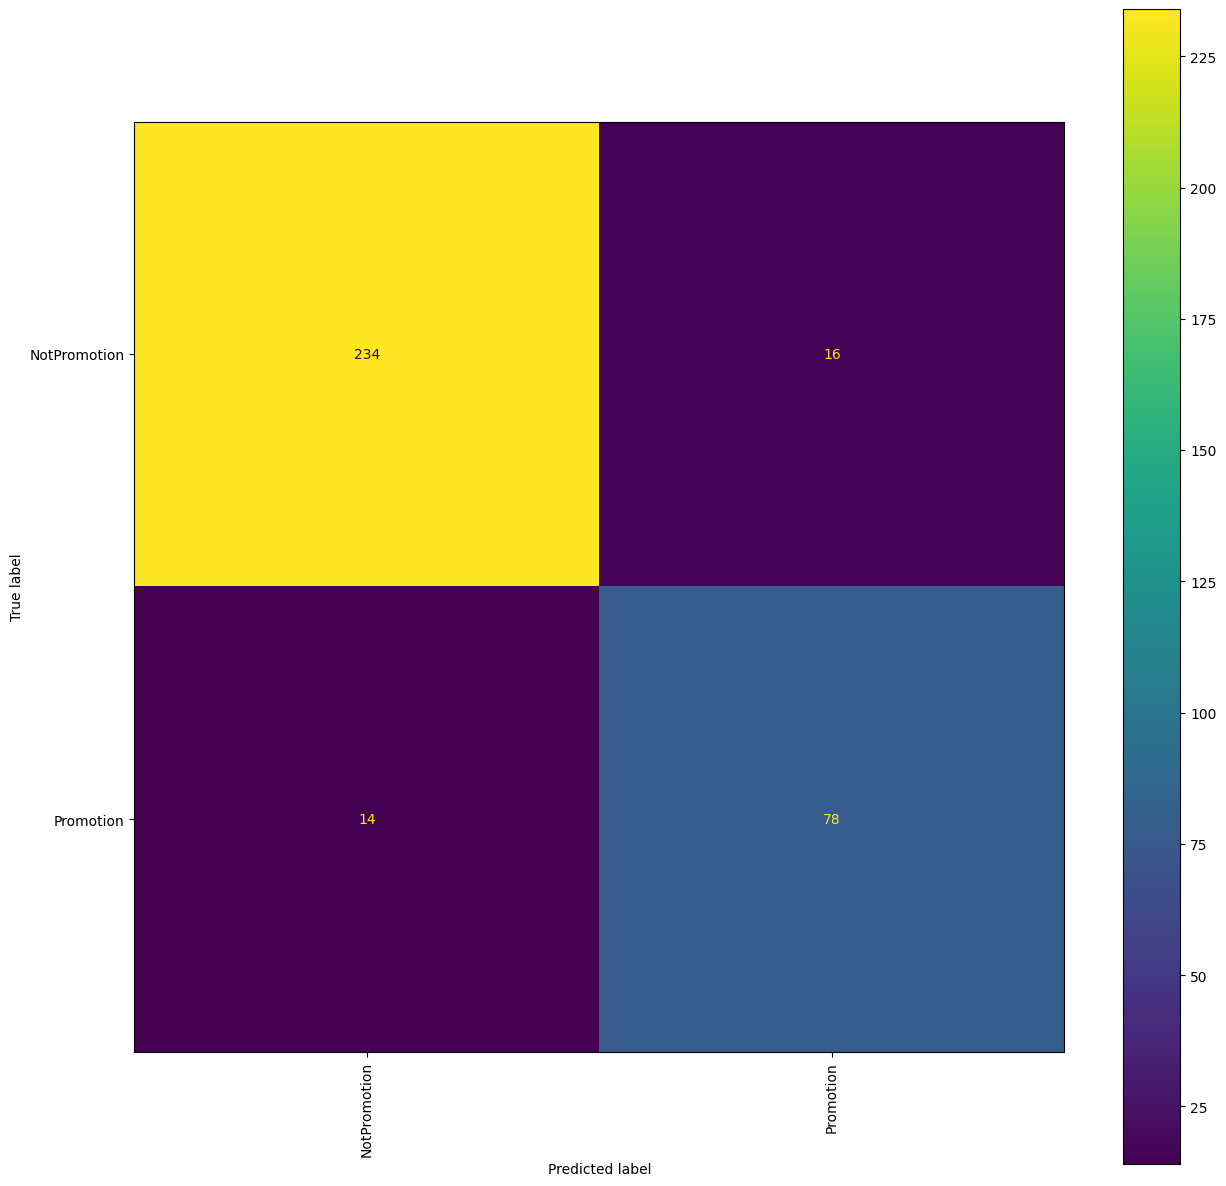

In [18]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       250
           1       0.79      0.76      0.78        93

    accuracy                           0.88       343
   macro avg       0.85      0.84      0.85       343
weighted avg       0.88      0.88      0.88       343

Accuracy: 0.8805
Precision: 0.7889
Recall: 0.7634
F1-score: 0.7760


In [20]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = rf_model.predict(X_test)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(y_test, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")

Best Threshold: 1.0000
Best F1-Score: 0.7826
Average Precision (AP) Score: 0.6710


In [25]:
# Evaluate model performance
pred = rf_model.predict(X_test)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8830
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       250
           1       0.78      0.78      0.78        92

    accuracy                           0.88       342
   macro avg       0.85      0.85      0.85       342
weighted avg       0.88      0.88      0.88       342

Precision: 0.7826
Recall: 0.7826
F1-score: 0.7826


In [22]:
fbeta_score(y_test, y_pred, average='binary', beta=0.5, pos_label=1)

0.782608695652174

Confusion Matrix:



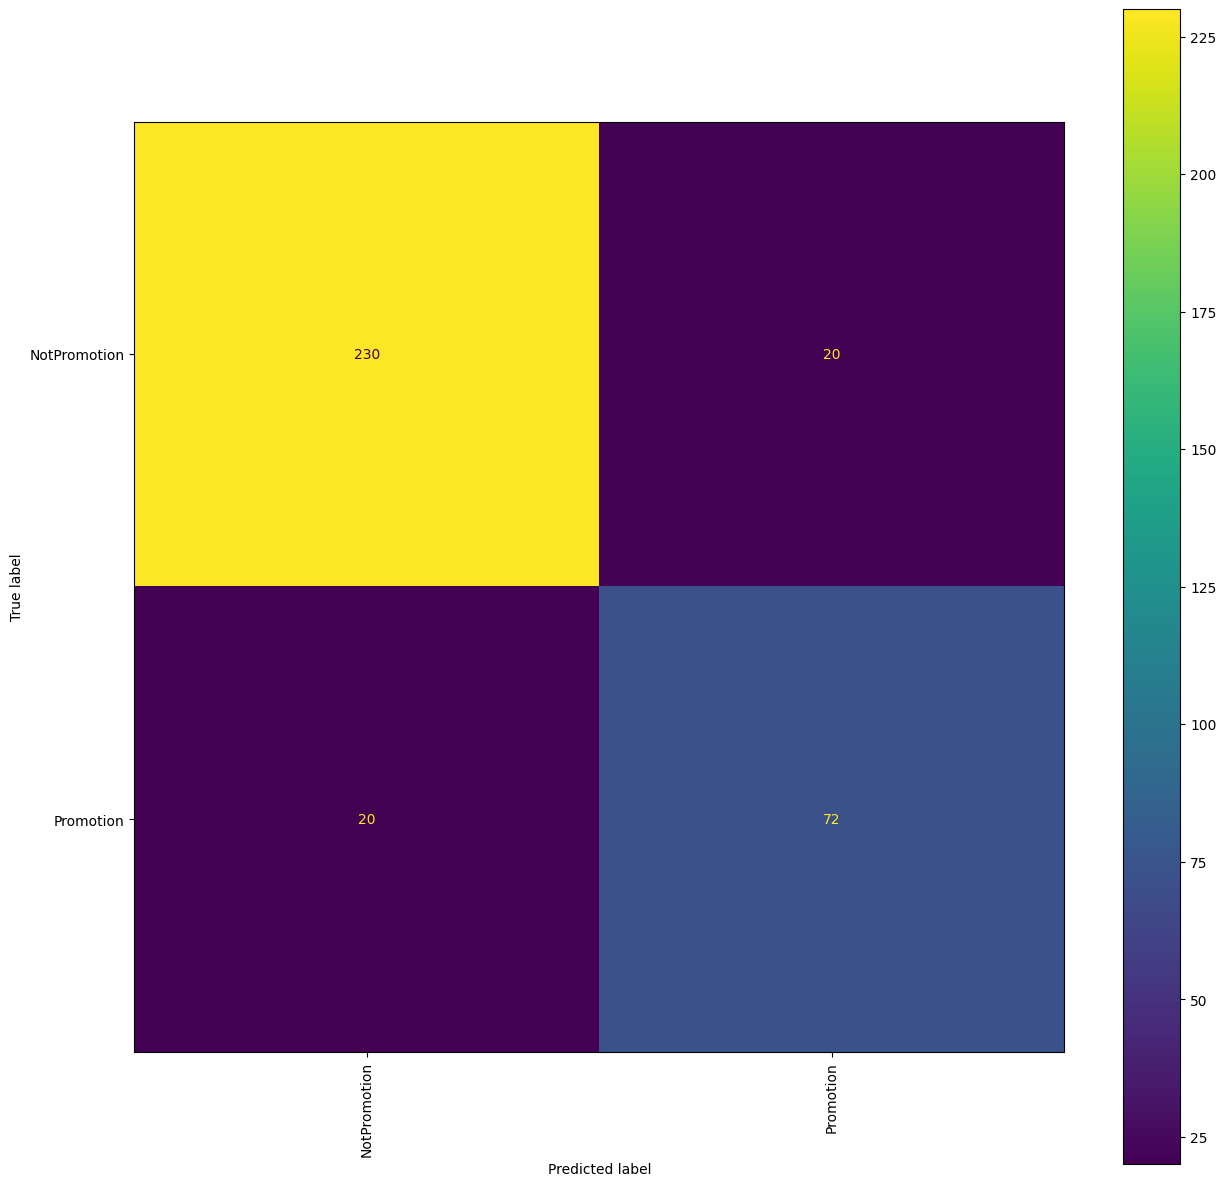

In [23]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')